In [10]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.quantum_info import random_unitary

import QuantumReservoirpy as QRP
from QuantumReservoirpy.utilities import memory_to_mean

from tqdm import tqdm

from sklearn.svm import SVC
from sklearn.linear_model import RidgeClassifier, Lasso, LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split



In [11]:

# Setup of circuits
mem_qubits = [0, 1, 2, 3]

timepart = [3, 1, 4, 1, 0, 2]
timeseries = timepart * 10 
ops = {
    key : random_unitary(2**len(mem_qubits)) for key in np.unique(timepart)
}


# Backwards horizon (M) needed to cover 95% (r) of all cases
M = 5
r = 0.95

# Dissipation
d =  (1 - r)**(1/M)
d = 0.8
print("Dissipation: ", d)

# Number of different circuits (different due to randomness)
SHOTS = 1000
num_subsystems = 50
subsystems = [0] * num_subsystems

n_features = len(mem_qubits) + 2 * M
results = np.zeros((len(timeseries), n_features))

for idx in tqdm(range(num_subsystems)):
    for l in range(2*M, len(timeseries)):
        qr = QuantumRegister(len(mem_qubits))
        cr = ClassicalRegister(len(mem_qubits))
        timeMeas = ClassicalRegister(2*M)
        circ = QuantumCircuit(qr, timeMeas, cr)
        circ.reset(qr)

        for i, time in enumerate(timeseries[l-2*M:l]):
            circ.unitary(ops[time], qr, label=f'{time}')
            circ.measure(0, timeMeas[i])
            if np.random.random() > d:
                circ.reset(qr)
        circ.measure(qr, cr)

        counts = QRP.utilities.simulate(circ, shots=SHOTS)#.get_counts()
        counts = [elem.replace(" ", "") for elem in counts]
        res = memory_to_mean(counts, 1).ravel()
        results[l] += res.copy()
        subsystems[idx] = circ

results /= (num_subsystems)

Dissipation:  0.8


100%|██████████| 50/50 [05:20<00:00,  6.40s/it]


(60, 2)
(60, 2)
Score of model: 0.7058823529411765


Text(0.5, 0.98, '[3, 1, 4, 1, 0, 2]')

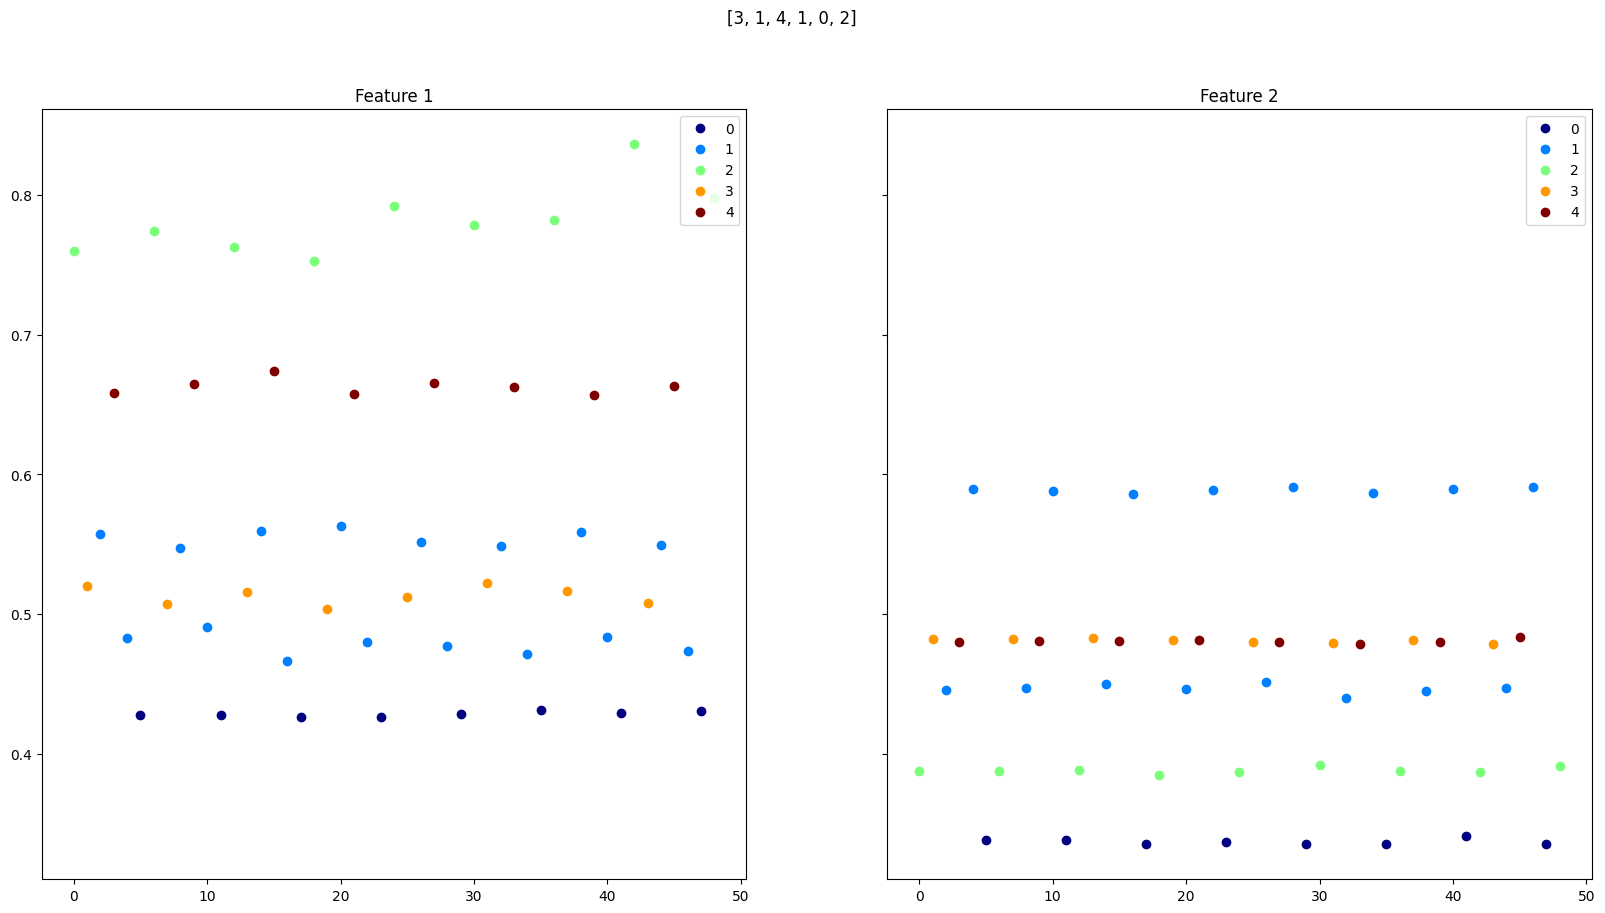

In [25]:
warmup = 2* M

print(results.shape)
# results = results.T[-len(mem_qubits) + 2:].T
print(results.shape)

temp = results[-1]
indeces = np.triu_indices(len(temp))
states = np.zeros((len(results), len(temp) + len(indeces[0])))
for i, res in enumerate(results):
    states[i] = np.concatenate((res, np.outer(res.T, res)[indeces]))
# print(np.outer(temp.T, temp)[np.triu_indices(len(temp))])
states = results
states = states[:-1]
target = timeseries[1:]

# states = states.T[-len(mem_qubits):].T
states = states[warmup:]
target = target[warmup:]
model = make_pipeline(StandardScaler(), SVC(gamma='auto', kernel='linear'))
# model = make_pipeline(StandardScaler(), RidgeClassifier(alpha=1e-2))
# model = RidgeClassifier(alpha=1e-2)

# model = make_pipeline(StandardScaler(), LogisticRegression(penalty='l1', solver='saga'))
# model = LogisticRegression(penalty='l2', solver='saga')

train_x, test_x, train_y, test_y = train_test_split(states, target, test_size=0.33)

clf = model.fit(train_x, train_y)
print(f'Score of model: {model.score(test_x, test_y)}')
fig, ax = QRP.utilities.result_plotter(states, target)
fig.suptitle(timepart)
# plt.savefig(f"Beautiful{SHOTS}-{num_subsystems}.pdf")


In [13]:
num_predictions = 20

pred_state = results[-1]
predictions = timeseries
for idx in tqdm(range(num_predictions)):
    pred = list(model.predict(pred_state.reshape((1, -1))))
    predictions = predictions + pred
    pred_state *= 0

    for idx in range(num_subsystems):
        qr = QuantumRegister(len(mem_qubits))
        cr = ClassicalRegister(len(mem_qubits))
        timeMeas = ClassicalRegister(2*M)
        circ = QuantumCircuit(qr, timeMeas, cr)
        circ.reset(qr)
        
        for i, time in enumerate(predictions[-2*M:]):
            circ.unitary(ops[time], qr, label=f'{time}')
            circ.measure(0, timeMeas[i])
            if np.random.random() > d:
                circ.reset(qr)
        circ.measure(qr, cr)

        counts = QRP.utilities.simulate(circ, shots=SHOTS)#.get_counts()
        counts = [elem.replace(" ", "") for elem in counts]
        res = memory_to_mean(counts, 1).ravel()

        pred_state += res[-len(mem_qubits):]

    pred_state /= num_subsystems


100%|██████████| 20/20 [02:01<00:00,  6.10s/it]


In [14]:
print(predictions[-num_predictions:])


[1, 4, 1, 0, 2, 1, 1, 4, 1, 0, 1, 1, 4, 1, 0, 0, 1, 1, 1, 4]
